In [31]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchmin import minimize_constr

In [32]:
N_skin = 400
N_bandage = 400

In [33]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.0099, 0.0014, 0.0013]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[0.0099, 0.0014, 0.0023],
                           [0.0099, 0.0014, 0.0033],
                           [0.0099, 0.0014, 0.0043],])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [34]:
contact_sur = torch.tensor([400, 401, 402, 403, 404, 406, 407, 408, 409, 416, 417, 418, 419, 420,
         421, 422, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 444,
         445, 447, 448, 450, 451, 452, 467, 468, 469, 470, 471, 472, 473, 474,
         475, 476, 478, 479, 492, 493, 494, 495, 496, 497, 506, 507, 508, 509,
         510, 511, 512, 513, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
         529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
         543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
         557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
         571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
         585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
         599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
         613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
         627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,
         641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
         655, 656, 657, 658, 659, 660, 661]) - 400

In [35]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.002), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0019, contact_sur)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 50)
# softbody.fix_less_than(1, 0.002, 2)

detect 2 object


In [36]:
norm_vec = np.array([-1, -1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


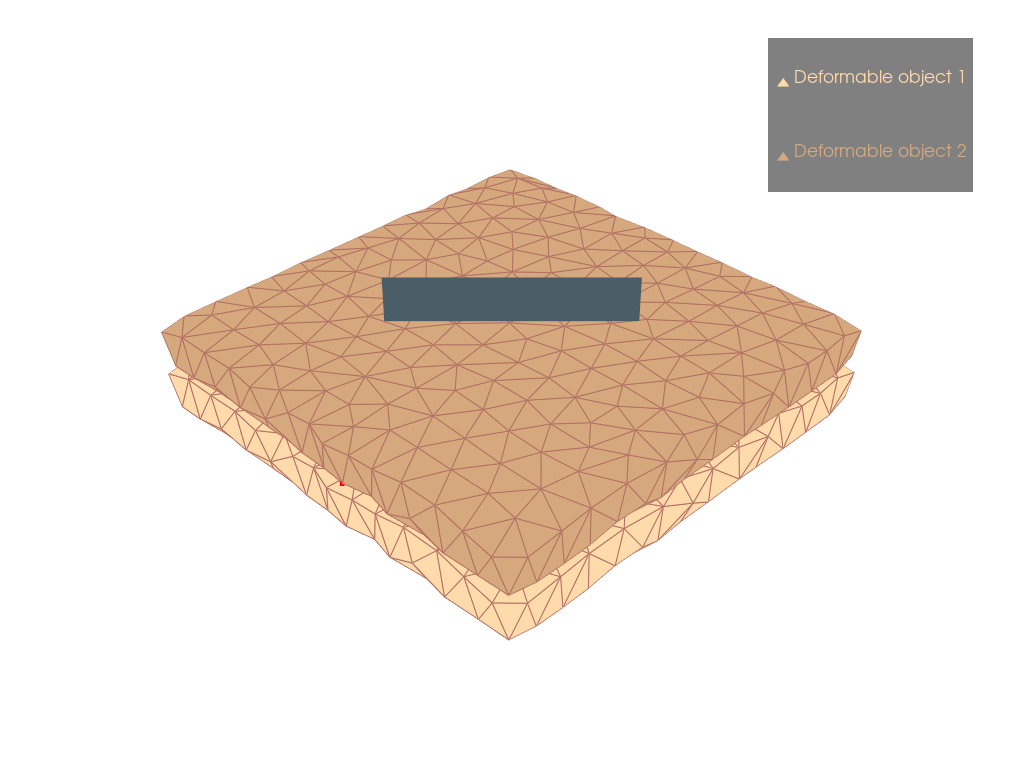

In [37]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + 50].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [38]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [39]:
softbody.C_boundary_list[0].shape

torch.Size([938, 2])

In [40]:
# color = np.zeros(400)
# color[306] = 1

In [41]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [42]:
# center = torch.tensor([0, 0, 0])
# N_norm = torch.norm(softbody.V_list[1][contact_sur] - center, dim=1)
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max -  N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min())
#     stiffness_color.append(energy_max - N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min()))

In [45]:
picked_stiffness = torch.from_numpy(np.array([228, 252, 253, 254, 205, 216, 215, 212, 211, 243, 213, 213, 213, 213, 261, 247, 257, 221, 222, 222, 222, 222, 227, 224, 232, 230]))
stiffness_color = []
for i in range(contact_sur.shape[0]):
    if contact_sur[i] in picked_stiffness:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


In [30]:
torch.sum(energy_threshold == 1e-7)

tensor(0)

In [46]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


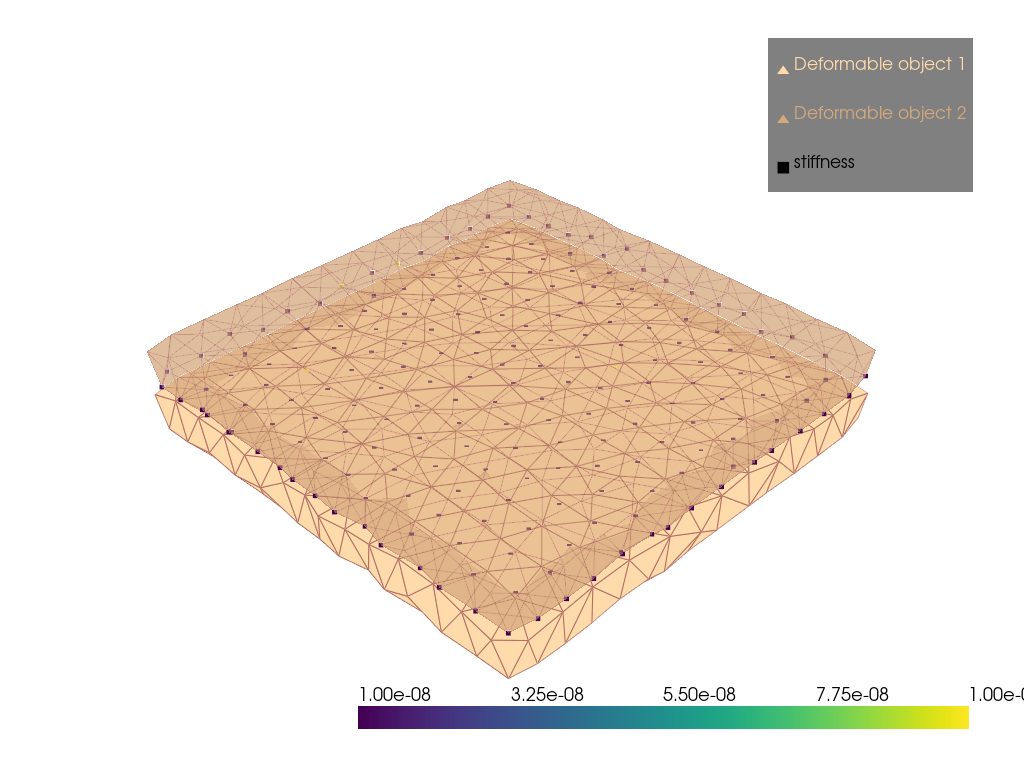

In [47]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [48]:
filename = 'tissue2tissue_stiffness_' + str(V_boundary_stiffness_ref) + '.gif'
stiffness_text = 'Boundary stiffness = ' + str(V_boundary_stiffness_ref)

In [49]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [50]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


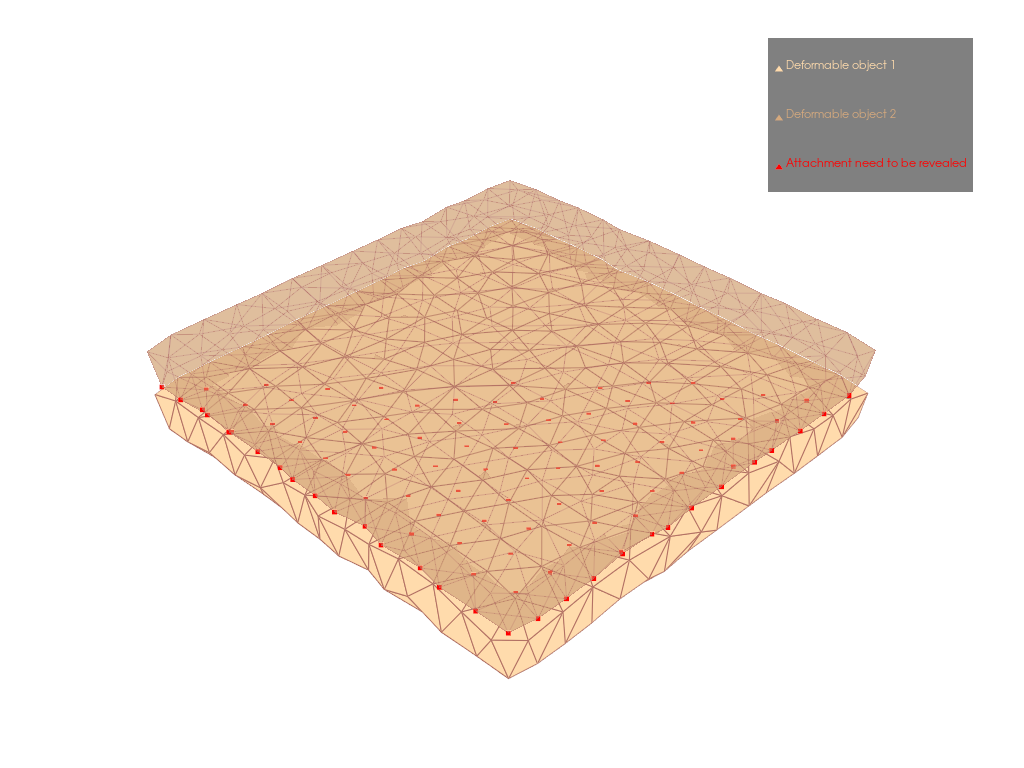

In [51]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [52]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 0.1
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [53]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0013])

In [54]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[0.0099, 0.0014, 0.0023],
        [0.0099, 0.0014, 0.0033],
        [0.0099, 0.0014, 0.0043]], dtype=torch.float64, requires_grad=True)

In [55]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [56]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target, penalty, alpha=1e5):
    return torch.norm(target - predict) + penalty * alpha

In [57]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [58]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0030])

In [59]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([938, 2])

In [60]:
spline_list = []

In [61]:
torch.sigmoid(torch.tensor(10))

tensor(1.0000)

itr 0
start simulation


100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


loss: tensor(1.7601, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.3195), tensor(1.))
constrain tensor(1.9287e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 94.3578,  12.5241, -36.0802],
        [ 78.3755,  14.3118,  41.3395],
        [ -4.8838,  27.6380, -15.5330]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


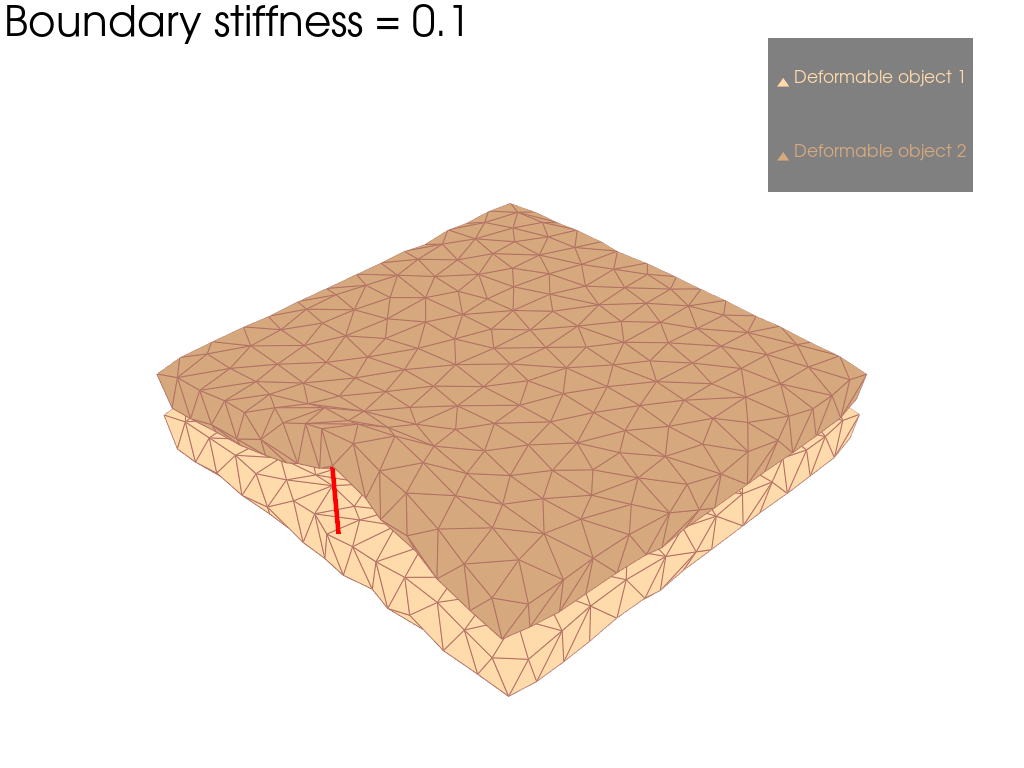

itr 1
start simulation


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


loss: tensor(1.4150, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.5602), tensor(0.9846))
constrain tensor(9.6338e-17, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-98.3459,  -3.6853,  23.3024],
        [-56.1603,   8.7550,  13.6052],
        [-16.9851,  64.9551,  -2.1683]], dtype=torch.float64)
itr 2
start simulation


 31%|███       | 4/13 [00:02<00:05,  1.67it/s]


KeyboardInterrupt: 

In [62]:

# pl.open_gif(filename)
for t in range(60):
    print('itr', t)
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = V_boundary_stiffness_origin.clone()
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    print('start simulation')
    for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + 50] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=True,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
        # energy_level = torch.abs(energy_threshold - energy) / (energy_threshold - energy)
        # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
        # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
        skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

    # loss = torch.norm(V_boundary_stiffness)
    constrain = torch.sigmoid(1e5 * (start_point[:, 2] - spline_trajectory[1:, 2]))
    constrain = torch.sum(constrain)
    loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, alpha=1)
    loss.backward()
    print('loss:', loss)
    print('Accuracy:', eval(V_boundary_stiffness, boundary_mask))
    print('constrain', constrain)
    print(spline_control.grad)
    spline_list.append(spline_trajectory)
    if t % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        pl.add_text(stiffness_text)
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = 'iso'
        pl.show()
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

In [31]:
# pl = pv.Plotter()
# pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
# pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_text(stiffness_text)
# # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
# pl.add_legend()
# pl.camera_position = 'iso'

In [32]:
# pl.open_gif('tissue2tissue_opt_dist+boundary+shape_various_stiffnes3_55_itrs.gif')
# for spline_trajectory in spline_list[::3]:
#     softbody.V = V_origin.clone()
#     softbody.V_velocity = V_velocity_origin.clone()

#     # restore stiffness
#     cloth_dist_stiffness = 1
#     V_boundary_stiffness_ref = 0.1
#     V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
#     V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
#     V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    
#     spline_actor = pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
#     for i in trange(spline_trajectory.shape[0]):
#         softbody.V[softbody.offset_list[1] + 50] = spline_trajectory[i]
        
#         step_ref = XPBDStep(softbody,
#                     V_dist_stiffness=V_dist_stiffness, 
#                     V_shape_stiffness=V_shape_stiffness,
#                     V_boundary_stiffness=V_boundary_stiffness, 
#                     dt=cfg.dt,
#                     substep=cfg.substep,
#                     iteration=cfg.iteration,
#                     quasi_static=cfg.quasi_static,
#                     plane_height=cfg.ground_plane_height, 
#                     use_shape_matching=True,
#                     use_spring_boundary=True,
#                     use_dist=True)
#         V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
#         softbody.V = V_ref.clone()
#         softbody.V_velocity = V_velocity_ref.clone()
#         # print((softbody.V == torch.inf).any())
#         ref_V_boundary_stiffness = V_boundary_stiffness.clone()
#         energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
#         V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
#         skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
#         bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
#         # print(V_boundary_stiffness)
#         pl.write_frame()
#     pl.remove_actor(spline_actor)
#     # loss = torch.norm(V_boundary_stiffness)

# pl.close()

100%|██████████| 21/21 [00:12<00:00,  1.73it/s]
